# Multi linear model

Single shot multi linear model

In [99]:
import pandas as pd
import tensorflow as tf

from window import WindowGenerator
import utils

In [100]:
def train_case(case_df, model, in_width, out_steps, max_epochs):
    """ Train model for given case df. Currently uses 20% of data for validation and 80% for training. """
    
    outlets = [ col for col in case_df.columns.values if col.startswith('outlet') ]
    column_indices = { name: i for i, name in enumerate(case_df.columns) }

    train_df, test_df, val_df = utils.train_test_val_split(case_df, test_size=0, val_size=0.2)
    # train_df, test_df, val_df = normalize_datasets(train_df, test_df, val_df)

    label_columns = outlets

    multi_window = WindowGenerator(
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        input_width=in_width,
        label_width=out_steps,
        shift=out_steps,
        label_columns=label_columns
    )

    history = model.fit(
        multi_window.train,
        epochs=max_epochs,
        validation_data=multi_window.val,
        verbose=0
        # callbacks=[early_stopping]
    )

    return multi_window, history

## Dataset

In [101]:
case_1 = pd.read_csv("../datasets/case_1.csv", index_col='Time')
case_2 = pd.read_csv("../datasets/case_2.csv", index_col='Time')
case_3 = pd.read_csv("../datasets/case_3.csv", index_col='Time')
case_4 = pd.read_csv("../datasets/case_4.csv", index_col='Time')
case_5 = pd.read_csv("../datasets/case_5.csv", index_col='Time')

In [102]:
outlets = [ col for col in case_1.columns.values if col.startswith('outlet') ]
label_columns = outlets

In [103]:
column_indices = { name: i for i, name in enumerate(case_1.columns) }

## Model creation

In [104]:
IN_WIDTH = 18
OUT_STEPS = 18
MAX_EPOCHS = 20
features_size = len(label_columns)

print(f"Using {IN_WIDTH*5}s of data to predict {OUT_STEPS*5}s into de future.")
print(f"Using {IN_WIDTH*5/60}min of data to predict {OUT_STEPS*5/60}min into de future.")

Using 90s of data to predict 90s into de future.
Using 1.5min of data to predict 1.5min into de future.


In [105]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(20, activation='relu'), # 512
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*features_size,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, features_size])
])

In [106]:
multi_linear_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.RootMeanSquaredError()])

## Case 2

In [107]:
window, history = train_case(case_2, multi_linear_model, IN_WIDTH, OUT_STEPS, MAX_EPOCHS)

2022-09-26 16:53:08.859108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-26 16:53:09.331599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [108]:
multi_linear_model.build(input_shape=window.example[0].shape)
multi_linear_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_5 (Lambda)           (None, 1, 273)            0         
                                                                 
 dense_10 (Dense)            (None, 1, 20)             5480      
                                                                 
 dense_11 (Dense)            (None, 1, 2448)           51408     
                                                                 
 reshape_5 (Reshape)         (None, 18, 136)           0         
                                                                 
Total params: 56,888
Trainable params: 56,888
Non-trainable params: 0
_________________________________________________________________


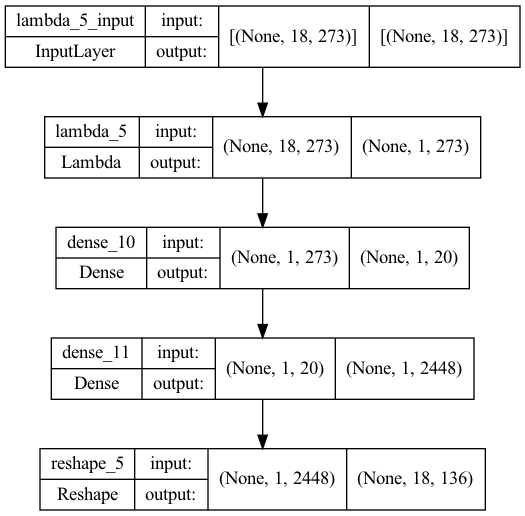

In [109]:
tf.keras.utils.plot_model(multi_linear_model, "../plots/models/multi_lineal.png", show_shapes=True)

label_col_index 135
label_col_index 135
label_col_index 135


2022-09-26 16:53:18.124259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


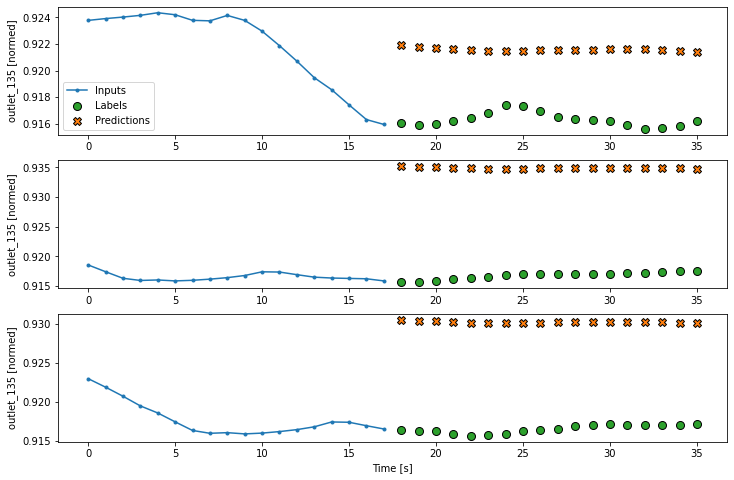

In [110]:
window.plot(multi_linear_model, plot_col="outlet_135")

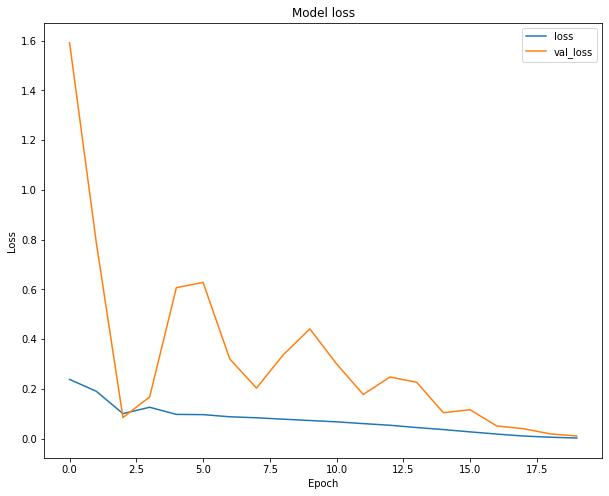

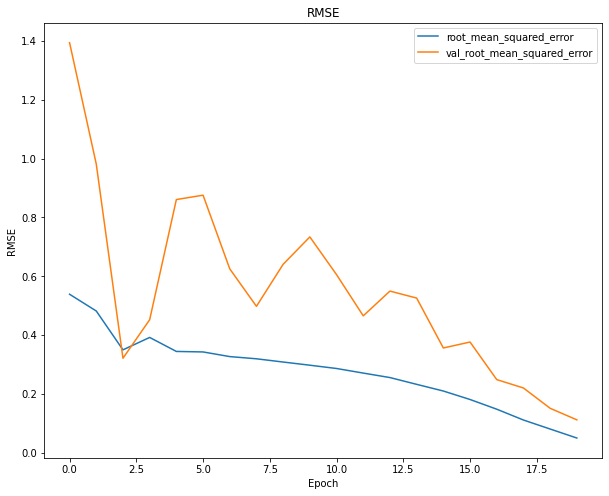

In [111]:
utils.plot_losses(history=history)

## Case 3

In [112]:
window, history = train_case(case_3, multi_linear_model, IN_WIDTH, OUT_STEPS, MAX_EPOCHS)

label_col_index 135
label_col_index 135
label_col_index 135


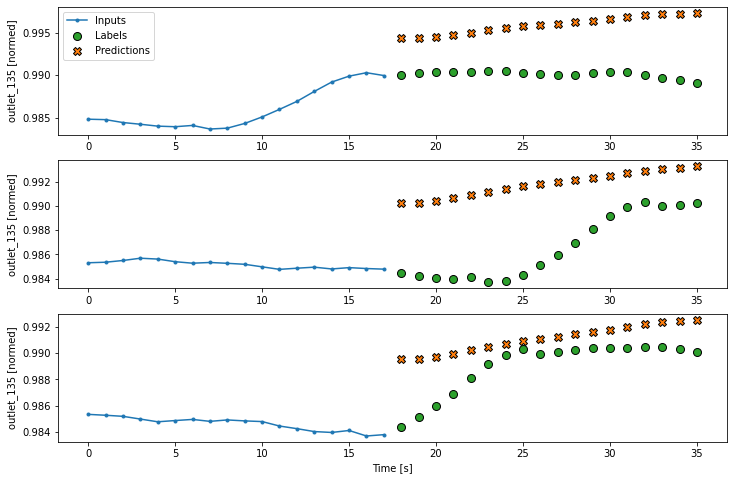

In [113]:
window.plot(multi_linear_model, plot_col="outlet_135")

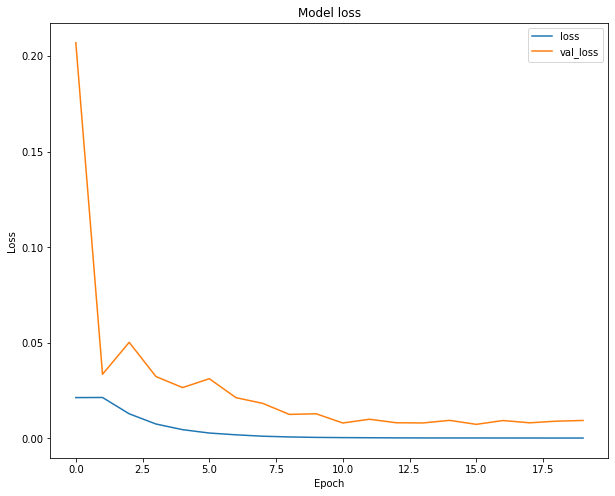

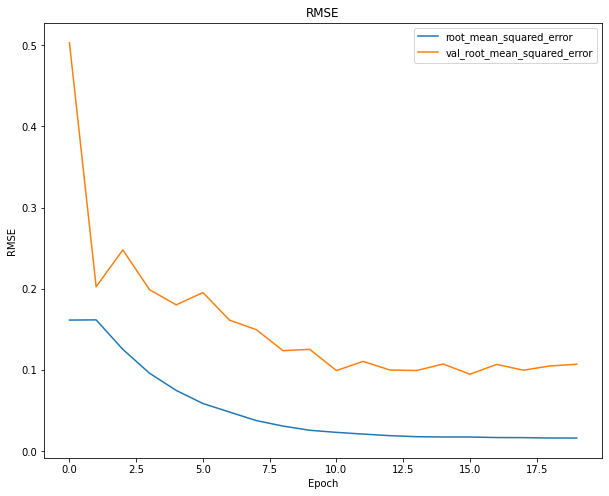

In [114]:
utils.plot_losses(history=history)

## Case 4

In [115]:
window, history = train_case(case_4, multi_linear_model, IN_WIDTH, OUT_STEPS, MAX_EPOCHS)

label_col_index 135
label_col_index 135
label_col_index 135


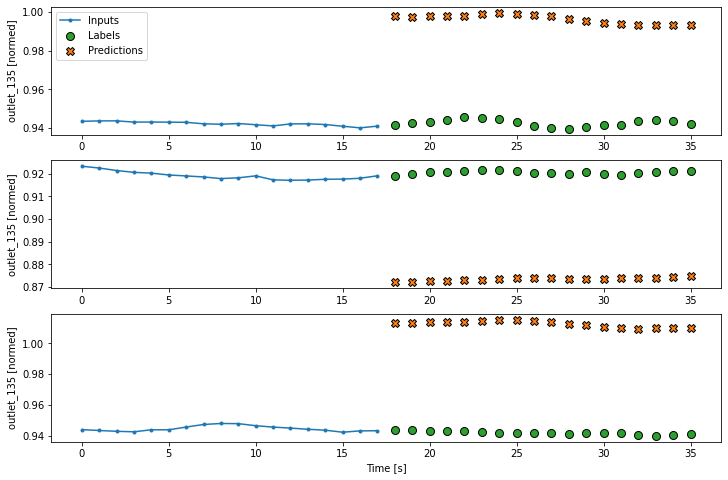

In [116]:
window.plot(multi_linear_model, plot_col="outlet_135")

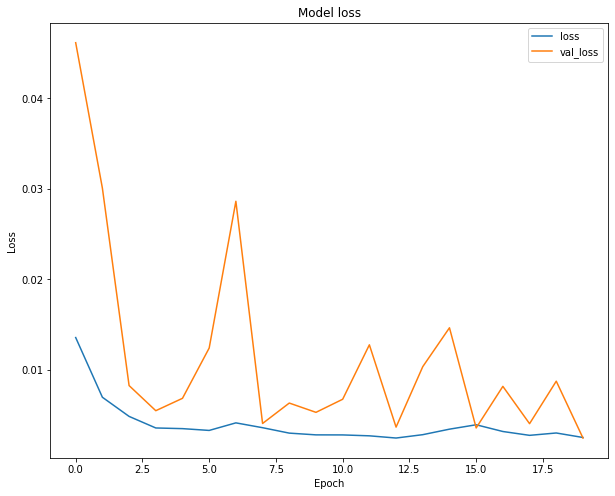

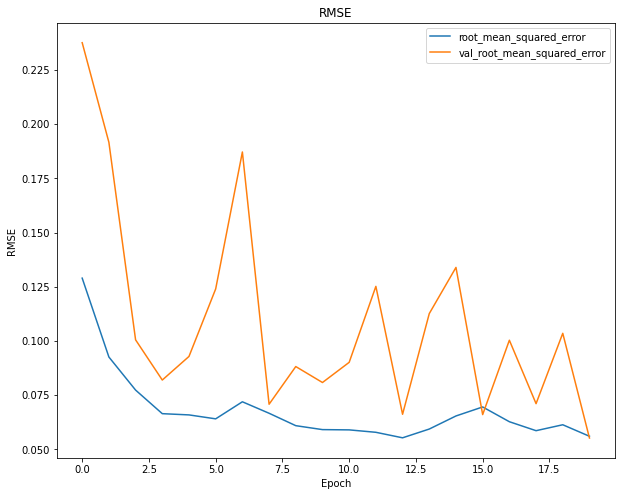

In [117]:
utils.plot_losses(history=history)

## Case 5

In [118]:
window, history = train_case(
    case_df=case_5,
    model=multi_linear_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

label_col_index 135
label_col_index 135
label_col_index 135


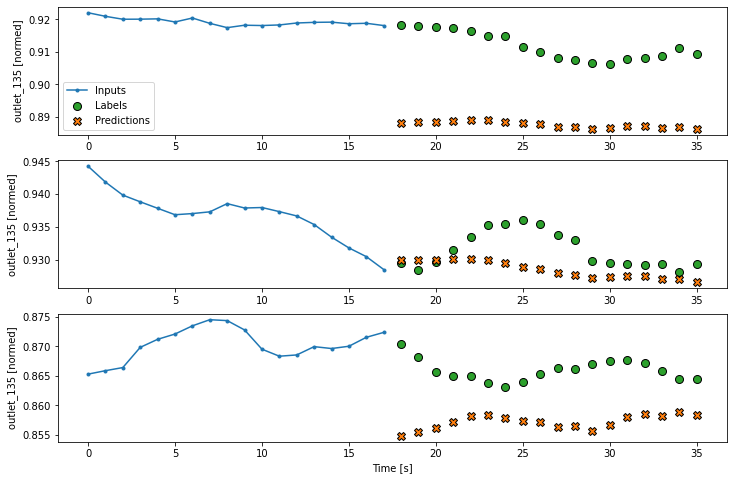

In [119]:
window.plot(multi_linear_model, plot_col="outlet_135")

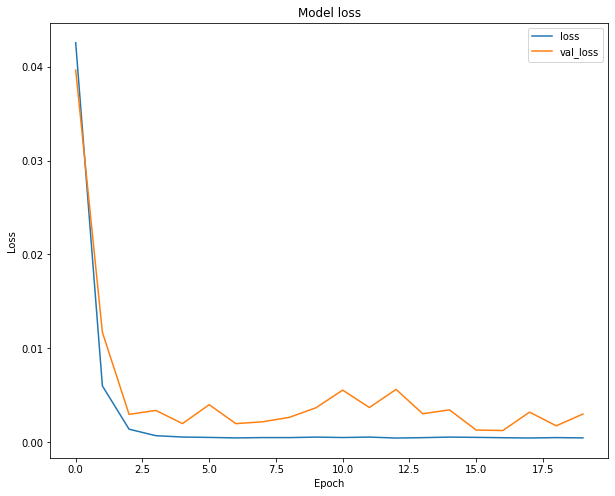

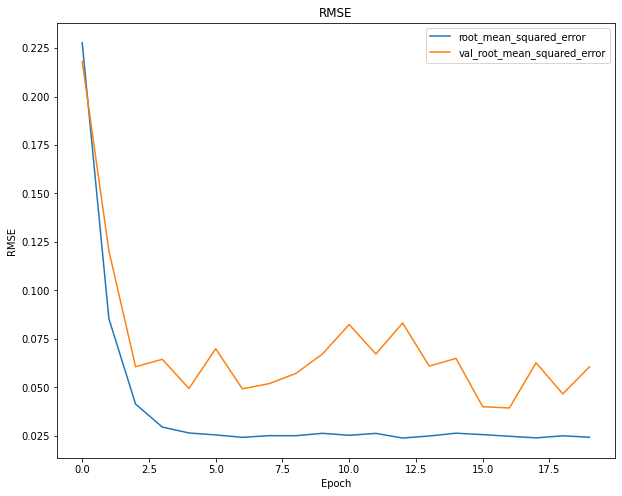

In [120]:
utils.plot_losses(history=history)

## Case 1 (Testing)

In [121]:
outlets = [ col for col in case_1.columns.values if col.startswith('outlet') ]
column_indices = { name: i for i, name in enumerate(case_1.columns) }

In [122]:
window = WindowGenerator(
    train_df=case_1,
    input_width=IN_WIDTH,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    label_columns=outlets
)

multi_linear_model.evaluate(window.train)

5/5 [==============================] - 0s 9ms/step - loss: 0.0227 - root_mean_squared_error: 0.1666


[0.022700462490320206, 0.16655510663986206]